<a href="https://colab.research.google.com/github/EmmaCOo/Consumer-Complaints-Dataset-for-NLP/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Classification of Consumer Complaints Using Natural Language Processing (NLP)**

##**Ivan Chavez, Emma Oo, and Andrew Kim**

###**ADS-504 Summer 2022**

###**August 14, 2022**



In [1]:
# Mount to shared drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import libraries

import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import string
from nltk.tokenize import word_tokenize
import re
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


### Load data set

In [3]:
df = pd.read_csv('/content/drive/MyDrive/ADS504_MachineLearning_GroupProject/Colab Notebooks/Data/complaints_processed.csv')
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


###**DATA PREPROCESSING**

### The 'product' will be the the target label and 'narrative' will be the features.

In [4]:
# Drop insignificant column 'Unnamed: 0'
df = df.drop(columns=['Unnamed: 0'], axis = 1)
df.tail(8)

,product,narrative
162413,mortgages_and_loans,zillow home loan nmls nmls actual quote provid...
162414,debt_collection,zuntafi sent notice willing settle defaulted s...
162415,debt_collection,name
162416,debt_collection,name
162417,credit_card,name
162418,debt_collection,name
162419,credit_card,name
162420,credit_reporting,name


**Not significant text 'name' are observed in the narrative feature. We will drop those records since they don't contribute any meaning.**

In [5]:
# drop the rows that contain 'name' 
df = df[df["narrative"].str.contains("name") == False] 
df.tail()

,product,narrative
162408,credit_card,set received item listed refunding account tha...
162409,retail_banking,yr thru expecting monies account deposit dolla...
162412,debt_collection,zero contact made debt supposedly resolved fou...
162413,mortgages_and_loans,zillow home loan nmls nmls actual quote provid...
162414,debt_collection,zuntafi sent notice willing settle defaulted s...


MISSING VALUES AND DUPLICATES

In [6]:
# check missing values
print((~df.duplicated()).sum())

105377


In [7]:
print('Lenght of Data Frame Before')
len(df)

Lenght of Data Frame Before


137583

In [8]:
# drop the duplicated records
df.drop_duplicates(keep=False,inplace=True)

In [9]:
print('Lenght of Data Frame After Dropping Duplicates:')
len(df)

Lenght of Data Frame After Dropping Duplicates:


94999

In [10]:
# data types and shape of the data
print(df.dtypes)
print(df.shape)

product      object
narrative    object
dtype: object
(94999, 2)


### **TARGET CLASSES**

### **DISTRIBUTION OF TARGET CLASSES**

In [11]:
# target classes' distribution
df['product'].value_counts(normalize=True)*100

credit_reporting       39.225676
debt_collection        17.580185
mortgages_and_loans    17.532816
credit_card            13.710671
retail_banking         11.950652
Name: product, dtype: float64

### **VISUAL DISTRIBUTION OF TARGET CLASSES**

Text(0.5, 1.0, 'Distribution of Target Classes')

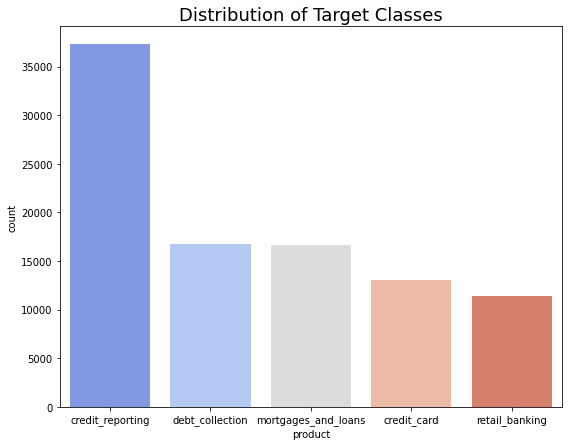

In [12]:
# Figure size
plt.figure(figsize=(9,7))

# Count plot
ax = sns.countplot(x = 'product', data = df, palette="coolwarm", order = df['product'].value_counts().index)

# Add title
plt.title('Distribution of Target Classes', fontsize=18)

**From the value_counts and countplot graph, the distribution of credit_reporting is highest with 56.2%, debt_collection (14.3%), mortgage_and_loans (11.7%), credit_card (9.6%),and retail_banking (8.3%).**

**Overall a slight class imbalance was observed between the target classes.**

### **LABEL ENCDOING OF TARGET CLASSES**

In [13]:
le = LabelEncoder()
df['product'] = le.fit_transform(df['product'])
df.head()

,product,narrative
0,0,purchase order day shipping amount receive pro...
2,4,forwarded message cc sent friday pdt subject f...
3,1,payment history missing credit report speciali...
4,1,payment history missing credit report made mis...
5,1,payment history missing credit report made mis...


In [14]:
df['product'].value_counts(normalize=True)*100

1    39.225676
2    17.580185
3    17.532816
0    13.710671
4    11.950652
Name: product, dtype: float64

After comparing the target contribution percentages before and after encoding, it's noted that 


*   Target Classes = Encoded Number
*   credit_card = 0
*   credit_reporting     = 1
*   debt_collection      = 2
*   mortgages_and_loans  = 3
*   retail_banking       = 4

### **PREPROCESSING FOR FEATURE COLUMN 'NARRATIVE'**

### REMOVE PUNCTUATION

In [15]:
import string
string.punctuation   # print lists of punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
# Function to remove punctuation
def remove_punc(text):
  text_nonpunc ="".join([char for char in str(text) if char not in string.punctuation])
  return text_nonpunc

# applyiing remove_punc function into 'narrative' and saving as a 'no_punctuation' column
df['no_punctuation'] = df['narrative'].apply(lambda x: remove_punc(x))

df.head()

,product,narrative,no_punctuation
0,0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...
2,4,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...
3,1,payment history missing credit report speciali...,payment history missing credit report speciali...
4,1,payment history missing credit report made mis...,payment history missing credit report made mis...
5,1,payment history missing credit report made mis...,payment history missing credit report made mis...


### TOKENIZATION 

Tokenization is a process of parsing the text string into different sections (tokens). 

In [17]:
#function to tokenize the text
def tokenize(text):
  tokens = re.split('\W+', text)
  return tokens

# add new column 'tokenized' to df
df['tokenized'] = df['no_punctuation'].apply(lambda x: tokenize(x)) # convert lower case to all words

df.head()

,product,narrative,no_punctuation,tokenized
0,0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...,"[purchase, order, day, shipping, amount, recei..."
2,4,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...,"[forwarded, message, cc, sent, friday, pdt, su..."
3,1,payment history missing credit report speciali...,payment history missing credit report speciali...,"[payment, history, missing, credit, report, sp..."
4,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma..."
5,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma..."


### REMOVING STOP WORDS

Stop words such as 'is', 'and', 'the' etc will be removed since they don't contritube much information for the NLP.  

For this project, spaCy library will be used. 

In [18]:
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
print(sw_spacy)

{'whoever', 'often', 'across', 'throughout', 'elsewhere', 'mostly', 'serious', 'much', 'call', 'have', 'while', 'up', 'by', 'we', 'again', 'for', 'because', 'two', 'which', 'otherwise', 'does', 'front', 'together', 'whom', 'nowhere', 'somehow', 'no', 'are', 'beforehand', "'m", 'due', "'re", 'almost', 'via', 'mine', '’ll', 'must', 'him', 'ten', 'quite', 'everything', 'then', 'therefore', 'be', 'against', 'since', 'side', 'six', 'there', 'is', 'my', 'none', 'on', 'whence', 'also', 'empty', 'me', 'he', 'above', 'upon', 'everyone', 'yours', 'more', '‘s', 'keep', 'own', 'ca', 'whereby', 'many', 'done', 'once', 'myself', 'part', 'twelve', 'what', 'they', 'always', 're', 'back', 'you', 'therein', 'had', 'yourselves', 'somewhere', 'hence', 'one', 'every', 'would', 'give', 'namely', 'further', 'seems', 'our', 'may', 'last', 'being', 'bottom', 'her', 'without', 'really', 'too', 'yet', 'hers', 'thus', 'toward', 'however', 'noone', 'could', 'both', 'except', 'with', 'before', "'ll", '’re', 'a', 'o

In [19]:
# function to remove stopwords
def remove_sw(tokenized_list):
  func_sw = [word for word in tokenized_list if word not in sw_spacy]
  return func_sw

# add new column 'no_stopword' to df
df['no_stopword'] = df['tokenized'].apply(lambda x: remove_sw(x))

df.head()

,product,narrative,no_punctuation,tokenized,no_stopword
0,0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...,"[purchase, order, day, shipping, amount, recei...","[purchase, order, day, shipping, receive, prod..."
2,4,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...,"[forwarded, message, cc, sent, friday, pdt, su...","[forwarded, message, cc, sent, friday, pdt, su..."
3,1,payment history missing credit report speciali...,payment history missing credit report speciali...,"[payment, history, missing, credit, report, sp...","[payment, history, missing, credit, report, sp..."
4,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma...","[payment, history, missing, credit, report, mi..."
5,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma...","[payment, history, missing, credit, report, mi..."


## **LEMMATIZATION**

Lemmatization is performed to remove the extra words such as "easily" to "easy" while keeping the context of the words.  

In [20]:
lm = nltk.WordNetLemmatizer()

def lemmat(tokenized_text):
  text = [lm.lemmatize(word) for word in tokenized_text]
  return text

# add new column 'lemmatized' to df
df['lemmatized'] = df['no_stopword'].apply(lambda x: lemmat(x))

df.head()

,product,narrative,no_punctuation,tokenized,no_stopword,lemmatized
0,0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...,"[purchase, order, day, shipping, amount, recei...","[purchase, order, day, shipping, receive, prod...","[purchase, order, day, shipping, receive, prod..."
2,4,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...,"[forwarded, message, cc, sent, friday, pdt, su...","[forwarded, message, cc, sent, friday, pdt, su...","[forwarded, message, cc, sent, friday, pdt, su..."
3,1,payment history missing credit report speciali...,payment history missing credit report speciali...,"[payment, history, missing, credit, report, sp...","[payment, history, missing, credit, report, sp...","[payment, history, missing, credit, report, sp..."
4,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma...","[payment, history, missing, credit, report, mi...","[payment, history, missing, credit, report, mi..."
5,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma...","[payment, history, missing, credit, report, mi...","[payment, history, missing, credit, report, mi..."


### LENGTH OF SAMPLE BEFORE AND AFTER PREPROCESSING 

In [21]:
df['length_before_cleaning'] = df['narrative'].apply(lambda x: len(x))  # length of raw texts
df['length_after_cleaning'] = df['lemmatized'].apply(lambda x: len(x))  # length of cleand words
df.head()

,product,narrative,no_punctuation,tokenized,no_stopword,lemmatized,length_before_cleaning,length_after_cleaning
0,0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...,"[purchase, order, day, shipping, amount, recei...","[purchase, order, day, shipping, receive, prod...","[purchase, order, day, shipping, receive, prod...",1705,203
2,4,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...,"[forwarded, message, cc, sent, friday, pdt, su...","[forwarded, message, cc, sent, friday, pdt, su...","[forwarded, message, cc, sent, friday, pdt, su...",1230,147
3,1,payment history missing credit report speciali...,payment history missing credit report speciali...,"[payment, history, missing, credit, report, sp...","[payment, history, missing, credit, report, sp...","[payment, history, missing, credit, report, sp...",903,110
4,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma...","[payment, history, missing, credit, report, mi...","[payment, history, missing, credit, report, mi...",851,102
5,1,payment history missing credit report made mis...,payment history missing credit report made mis...,"[payment, history, missing, credit, report, ma...","[payment, history, missing, credit, report, mi...","[payment, history, missing, credit, report, mi...",849,102


### **VISUALIZATIONS OF MOST FREQUENT USED WORDS FROM ORIGINAL TEXT SENTENCES VS LEMMATIZED WORDS**


####TOP 10 MOST FREQUENTS WORDS FROM THE ORIGINAL WORDS

In [22]:
# Top 10 Most Used Words from the raw narrative column
from collections import Counter
count = Counter(" ".join(df["narrative"]).split()).most_common(10)
print(count)

[('account', 173252), ('credit', 169709), ('payment', 94453), ('report', 83508), ('information', 65332), ('time', 54238), ('loan', 53798), ('would', 53554), ('card', 50663), ('bank', 49455)]


In [23]:
raw_top = pd.DataFrame(count, columns = ['Words','Frequency'])
raw_top

,Words,Frequency
0,account,173252
1,credit,169709
2,payment,94453
3,report,83508
4,information,65332
5,time,54238
6,loan,53798
7,would,53554
8,card,50663
9,bank,49455



####TOP 10 MOST FREQUENTS WORDS FROM LEMMATIZED WORDS

In [24]:
reviews = df["lemmatized"].values.tolist()
flat_list = [item for elem in reviews for item in elem if str(item) != 'nan']

fdist1 = nltk.FreqDist(flat_list)
lem_top = pd.DataFrame(fdist1.most_common(10), columns = ['Words','Frequency'])
lem_top

,Words,Frequency
0,account,173252
1,credit,169709
2,payment,94453
3,report,83508
4,information,65332
5,time,54238
6,loan,53798
7,card,50664
8,bank,49455
9,company,47495


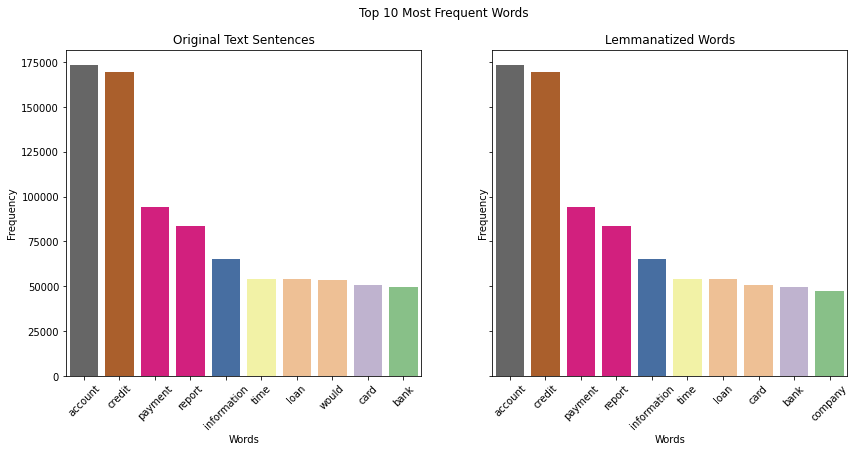

In [25]:
fig, ax = plt.subplots(1,2, figsize=(14,6), sharey=True)
fig.suptitle('Top 10 Most Frequent Words')

sns.barplot(x='Words', y= 'Frequency', data = raw_top , palette = 'Accent_r', ax = ax[0])
sns.barplot(x='Words', y= 'Frequency', data = lem_top , palette = 'Accent_r', ax = ax[1])

ax[0].set_title('Original Text Sentences')
ax[1].set_title('Lemmanatized Words')

ax[0].tick_params(axis='x', labelrotation=45)
ax[1].tick_params(axis='x', labelrotation=45)
fig.show()

### **DATA PARTITIONING** 

In [26]:
# Clean Data Frame with only 'product' and 'lemmatized' columns
clean_df = df[['product','lemmatized']]

# split feature and target column 
X = clean_df['lemmatized']
y = df[['product']]

print(X.head())
print(y.head())

0    [purchase, order, day, shipping, receive, prod...
2    [forwarded, message, cc, sent, friday, pdt, su...
3    [payment, history, missing, credit, report, sp...
4    [payment, history, missing, credit, report, mi...
5    [payment, history, missing, credit, report, mi...
Name: lemmatized, dtype: object
   product
0        0
2        4
3        1
4        1
5        1


###**TF-IDF VECTORIZATION**

Vectorization is to convert the text data into numerical data/vector for the NLP machine learning. TF-IDF method will be used for this project. 

In [27]:
X_array = X.astype(str)

In [28]:
# Vectorization
# for train data set
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X_array)

# get feature names
feat_names = vectorizer.get_feature_names()
feat_names

# create da data frame called X from bag of words features
X_tf = pd.DataFrame.sparse.from_spmatrix(X_vec, columns = feat_names)
X_tf.head()

,aa,aaa,aaadvantage,aaarrrrgghhhhhh,aab,aac,aaccount,aacount,aadvantage,aadvantages,...,zombie,zone,zoned,zoning,zoo,zoom,zoomed,zsaleh,zuntafi,zwicker
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# train(70%) and test (30%) splitting with stratified samples
X_train, X_test, y_train, y_test = train_test_split(X_tf,y, test_size = 0.3, random_state = 42, stratify = y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((66499, 38924), (66499, 1), (28500, 38924), (28500, 1))

###**FEATURE SELECTION USING SELECTKBest**

We are going to do four separate data sets named small(k=50), medium (k=500), large(1000), and extra large(k=3000) using the train data set and the feature selection SelectKBest to see the effects of the feature columns' sizes for our trained models.   

####Small Vocab List (k=50)

In [30]:
from sklearn.feature_selection import SelectKBest, chi2
kbest = SelectKBest(chi2,k=50)
kbest = kbest.fit(X_train, y_train)
X_train_small = kbest.transform(X_train)
X_test_small = kbest.transform(X_test)

In [31]:
import scipy.sparse
X_train_small = pd.DataFrame(X_train_small.todense(), columns = X_train.columns[kbest.get_support()].tolist())
X_test_small = pd.DataFrame(X_test_small.todense(), columns = X_test.columns[kbest.get_support()].tolist())

#### Medium Vocab List (k = 500)

In [32]:
from sklearn.feature_selection import SelectKBest, chi2
kbest = SelectKBest(chi2,k=500)
kbest = kbest.fit(X_train, y_train)
X_train_medium = kbest.transform(X_train)
X_test_medium = kbest.transform(X_test)

In [33]:
import scipy.sparse
X_train_medium = pd.DataFrame(X_train_medium.todense(), columns = X_train.columns[kbest.get_support()].tolist())
X_test_medium = pd.DataFrame(X_test_medium.todense(), columns = X_test.columns[kbest.get_support()].tolist())

#### Large Vocab List (k = 1000)

In [34]:
from sklearn.feature_selection import SelectKBest, chi2
kbest = SelectKBest(chi2,k=1000)
kbest = kbest.fit(X_train, y_train)
X_train_large = kbest.transform(X_train)
X_test_large = kbest.transform(X_test)

In [35]:
import scipy.sparse
X_train_large = pd.DataFrame(X_train_large.todense(), columns = X_train.columns[kbest.get_support()].tolist())
X_test_large = pd.DataFrame(X_test_large.todense(), columns = X_test.columns[kbest.get_support()].tolist())

#### Extra Large Vocab List (k = 3000)

In [36]:
from sklearn.feature_selection import SelectKBest, chi2
kbest = SelectKBest(chi2,k=3000)
kbest = kbest.fit(X_train, y_train)
X_train_xlarge = kbest.transform(X_train)
X_test_xlarge = kbest.transform(X_test)

In [37]:
import scipy.sparse
X_train_xlarge = pd.DataFrame(X_train_xlarge.todense(), columns = X_train.columns[kbest.get_support()].tolist())
X_test_xlarge = pd.DataFrame(X_test_xlarge.todense(), columns = X_test.columns[kbest.get_support()].tolist())

### Pickle Fitted Kbest Model

In [38]:
# Uncomment to update kbest fitted model
#import pickle
#filename = 'kbest.sav'
#pickle.dump(kbest, open(filename, 'wb'))

### Storing Dataset

In [39]:
# Uncomment to update data csv files
#X_train_small.to_csv('/content/drive/MyDrive/ADS504_MachineLearning_GroupProject/Colab Notebooks/Data/X_train_small.csv', header=True)
#X_train_medium.to_csv('/content/drive/MyDrive/ADS504_MachineLearning_GroupProject/Colab Notebooks/Data/X_train_medium.csv', header=True)
#X_train_large.to_csv('/content/drive/MyDrive/ADS504_MachineLearning_GroupProject/Colab Notebooks/Data/X_train_large.csv', header=True)
#X_train_xlarge.to_csv('/content/drive/MyDrive/ADS504_MachineLearning_GroupProject/Colab Notebooks/Data/X_train_xlarge.csv', header=True)

#X_test_small.to_csv('/content/drive/MyDrive/ADS504_MachineLearning_GroupProject/Colab Notebooks/Data/X_test_small.csv', header=True)
#X_test_medium.to_csv('/content/drive/MyDrive/ADS504_MachineLearning_GroupProject/Colab Notebooks/Data/X_test_medium.csv', header=True)
#X_test_large.to_csv('/content/drive/MyDrive/ADS504_MachineLearning_GroupProject/Colab Notebooks/Data/X_test_large.csv', header=True)
#X_test_xlarge.to_csv('/content/drive/MyDrive/ADS504_MachineLearning_GroupProject/Colab Notebooks/Data/X_test_xlarge.csv', header=True)

#y_train.to_csv('/content/drive/MyDrive/ADS504_MachineLearning_GroupProject/Colab Notebooks/Data/y_train.csv', header=True)
#y_test.to_csv('/content/drive/MyDrive/ADS504_MachineLearning_GroupProject/Colab Notebooks/Data/y_test.csv', header=True)

###**MODELS**

For this project, we will be training the following models with different types of hyparameter tunings. 

1) Baseline Model with Dummmy Classifier

2) Random Forest

3) Perceptron

4) Support Vecotr Machine (SVM) 

5) Stochastic Gradient Descent (SGD) 


####**BASE LINE MODEL**

First, we are going to implement the base line model using the Scikit-Learn Dummy Classifier to compare against other more complex classifiers. 

In [40]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train_xlarge, y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [41]:
# make predictions using fitted model
dummy_train_pred = dummy_clf.predict(X_train_xlarge)
dummy_test_pred = dummy_clf.predict(X_test_xlarge)

In [42]:
target_names = ['Credit Card', 'Credit Reporting', 'Debt Collection','Mortgages & Loans', 'Retail Banking']
dummy_cr = (classification_report(y_test, dummy_test_pred, target_names=target_names))
print(dummy_cr)

                   precision    recall  f1-score   support

      Credit Card       0.00      0.00      0.00      3908
 Credit Reporting       0.39      1.00      0.56     11179
  Debt Collection       0.00      0.00      0.00      5010
Mortgages & Loans       0.00      0.00      0.00      4997
   Retail Banking       0.00      0.00      0.00      3406

         accuracy                           0.39     28500
        macro avg       0.08      0.20      0.11     28500
     weighted avg       0.15      0.39      0.22     28500



###**RANDOM FOREST**

We will train Random Forest Model with small, medium, large, and extra large data sets after finding the optimal max_depth. 

####RANDOM FOREST HYERPARAMETER TUNING TO FIND THE OPTIMAL MAX-DEPTH 

In [43]:
from sklearn.ensemble import RandomForestClassifier

train_errors = list()
test_errors = list()

for i in range(1,40):
  rf_model = RandomForestClassifier(max_depth=i)    #Create multiple models here each based on the i variable above
  rf_model.fit(X_train_small,y_train)
  train_pred = rf_model.predict(X_train_small)
  test_pred = rf_model.predict(X_test_small)
  train_errors.append(accuracy_score(y_train,train_pred))    # Store the result of modes in t_train_erors and t_test_errors variables
  test_errors.append(accuracy_score(y_test, test_pred))


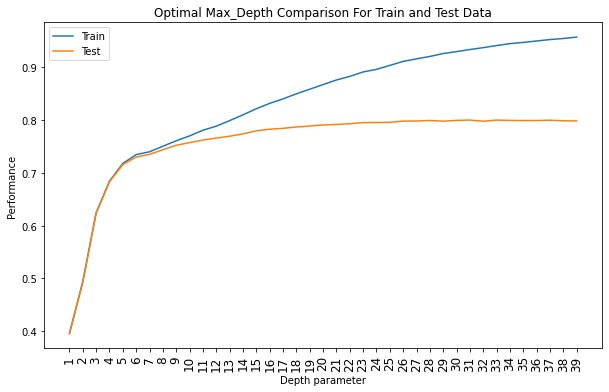

In [44]:
# Plot of test and training errors
fig,ax = plt.subplots(figsize=(10,6))
plt.plot(range(1,40),train_errors, label='Train')
plt.plot(range(1,40),test_errors, label='Test')
plt.title('Optimal Max_Depth Comparison For Train and Test Data')
plt.legend(loc='upper left')
plt.xlabel('Depth parameter')
plt.ylabel('Performance')
plt.xticks(ticks =np.arange(1,40,1), rotation = 90, size= 12);

**From the graph, the maximum performance is observed around 35 and after for the training data set. We will use max_depth of 35 for all the Random Forest models.**

### Random Forest For Small Features

In [45]:
# Small data set
rf = RandomForestClassifier(max_depth = 35, class_weight='balanced')

small_rf = rf.fit(X_train,y_train)

small_rf_pred= small_rf.predict(X_test)

small_rf_accuracy = accuracy_score(y_test, small_rf_pred)

# classification report
target_names = ['Credit Card', 'Credit Reporting', 'Debt Collection','Mortgages & Loans', 'Retail Banking']
print(classification_report(y_test, small_rf_pred, target_names=target_names))

                   precision    recall  f1-score   support

      Credit Card       0.77      0.77      0.77      3908
 Credit Reporting       0.88      0.85      0.87     11179
  Debt Collection       0.80      0.75      0.77      5010
Mortgages & Loans       0.83      0.86      0.84      4997
   Retail Banking       0.78      0.90      0.83      3406

         accuracy                           0.83     28500
        macro avg       0.81      0.83      0.82     28500
     weighted avg       0.83      0.83      0.83     28500



### Random Forest For Medium Features

In [46]:
# Medium data st
med_rf = rf.fit(X_train_medium,y_train)

med_rf_pred= med_rf.predict(X_test_medium)

med_rf_accuracy = accuracy_score(y_test, med_rf_pred)

# classification report
target_names = ['Credit Card', 'Credit Reporting', 'Debt Collection','Mortgages & Loans', 'Retail Banking']
print(classification_report(y_test, med_rf_pred,target_names=target_names))

                   precision    recall  f1-score   support

      Credit Card       0.78      0.78      0.78      3908
 Credit Reporting       0.87      0.87      0.87     11179
  Debt Collection       0.78      0.76      0.77      5010
Mortgages & Loans       0.85      0.83      0.84      4997
   Retail Banking       0.81      0.87      0.84      3406

         accuracy                           0.83     28500
        macro avg       0.82      0.82      0.82     28500
     weighted avg       0.83      0.83      0.83     28500



### Random Forest For Large Features



In [47]:
# Large data set
large_rf = rf.fit(X_train_large,y_train)

large_rf_pred= large_rf.predict(X_test_large)

large_rf_accuracy = accuracy_score(y_test, large_rf_pred)

# classification report
target_names = ['Credit Card', 'Credit Reporting', 'Debt Collection','Mortgages & Loans', 'Retail Banking']
print(classification_report(y_test, large_rf_pred, target_names=target_names))

                   precision    recall  f1-score   support

      Credit Card       0.78      0.78      0.78      3908
 Credit Reporting       0.87      0.87      0.87     11179
  Debt Collection       0.79      0.77      0.78      5010
Mortgages & Loans       0.85      0.84      0.85      4997
   Retail Banking       0.80      0.87      0.84      3406

         accuracy                           0.83     28500
        macro avg       0.82      0.82      0.82     28500
     weighted avg       0.83      0.83      0.83     28500



### Random Forest For Extra Large Features

In [48]:
# Large data set
xlarge_rf = rf.fit(X_train_xlarge,y_train)

xlarge_rf_pred= large_rf.predict(X_test_xlarge)

xlarge_rf_accuracy = accuracy_score(y_test, xlarge_rf_pred)

# classification report
target_names = ['Credit Card', 'Credit Reporting', 'Debt Collection','Mortgages & Loans', 'Retail Banking']
print(classification_report(y_test, xlarge_rf_pred, target_names=target_names))

                   precision    recall  f1-score   support

      Credit Card       0.77      0.78      0.78      3908
 Credit Reporting       0.88      0.86      0.87     11179
  Debt Collection       0.79      0.77      0.78      5010
Mortgages & Loans       0.84      0.85      0.84      4997
   Retail Banking       0.80      0.88      0.84      3406

         accuracy                           0.83     28500
        macro avg       0.82      0.83      0.82     28500
     weighted avg       0.83      0.83      0.83     28500



**For Random Forest models, the accuracy and F1 scores are almost identical for all different set of features. Thus, feature selections don't have much effect on the Random forest models.**

###**PERCEPTRON**

### Perceptron with Max_Iter = 1

###Perceptron For Small Features

In [49]:
from sklearn.linear_model import Perceptron

perceptron_clf = Perceptron(max_iter=1, class_weight='balanced', random_state=42).fit(X_train_small, y_train.values.ravel())

y_train_pred = perceptron_clf.predict(X_train_small)
y_test_pred = perceptron_clf.predict(X_test_small)

target_names = ['Credit Card', 'Credit Reporting', 'Debt Collection','Mortgages & Loans', 'Retail Banking']
print(classification_report(y_test, y_test_pred, target_names=target_names))

                   precision    recall  f1-score   support

      Credit Card       0.76      0.60      0.67      3908
 Credit Reporting       0.81      0.75      0.78     11179
  Debt Collection       0.83      0.38      0.52      5010
Mortgages & Loans       0.52      0.93      0.67      4997
   Retail Banking       0.74      0.84      0.79      3406

         accuracy                           0.71     28500
        macro avg       0.73      0.70      0.69     28500
     weighted avg       0.75      0.71      0.70     28500



###Perceptron For Medium Features

In [50]:
perceptron_clf = Perceptron(max_iter=1, class_weight='balanced', random_state=42).fit(X_train_medium, y_train.values.ravel())

y_train_pred = perceptron_clf.predict(X_train_medium)
y_test_pred = perceptron_clf.predict(X_test_medium)

print(classification_report(y_test, y_test_pred, target_names=target_names))

                   precision    recall  f1-score   support

      Credit Card       0.80      0.69      0.74      3908
 Credit Reporting       0.85      0.78      0.81     11179
  Debt Collection       0.85      0.50      0.63      5010
Mortgages & Loans       0.59      0.94      0.72      4997
   Retail Banking       0.78      0.90      0.83      3406

         accuracy                           0.76     28500
        macro avg       0.77      0.76      0.75     28500
     weighted avg       0.79      0.76      0.76     28500



###Perceptron For Large Features

In [51]:
perceptron_clf = Perceptron(max_iter=1, class_weight='balanced', random_state=42).fit(X_train_large, y_train.values.ravel())

y_train_pred = perceptron_clf.predict(X_train_large)
y_test_pred = perceptron_clf.predict(X_test_large)

print(classification_report(y_test, y_test_pred, target_names=target_names))

                   precision    recall  f1-score   support

      Credit Card       0.59      0.89      0.71      3908
 Credit Reporting       0.89      0.75      0.81     11179
  Debt Collection       0.83      0.60      0.70      5010
Mortgages & Loans       0.71      0.90      0.80      4997
   Retail Banking       0.87      0.82      0.84      3406

         accuracy                           0.78     28500
        macro avg       0.78      0.79      0.77     28500
     weighted avg       0.80      0.78      0.78     28500



###Perceptron for Xlarge Features

In [52]:
perceptron_clf = Perceptron(max_iter=1, class_weight='balanced', random_state=42).fit(X_train_xlarge, y_train.values.ravel())

per_train_pred = perceptron_clf.predict(X_train_xlarge)
per_test_pred = perceptron_clf.predict(X_test_xlarge)

print(classification_report(y_test, per_test_pred, target_names=target_names))

                   precision    recall  f1-score   support

      Credit Card       0.71      0.82      0.76      3908
 Credit Reporting       0.86      0.82      0.84     11179
  Debt Collection       0.82      0.68      0.74      5010
Mortgages & Loans       0.80      0.85      0.82      4997
   Retail Banking       0.80      0.89      0.84      3406

         accuracy                           0.81     28500
        macro avg       0.80      0.81      0.80     28500
     weighted avg       0.81      0.81      0.81     28500



### Perceptron (max_iter = 10) & Xtra Large Words


In [53]:
perceptron_clf = Perceptron(max_iter=10,class_weight='balanced', random_state=42).fit(X_train_xlarge, y_train.values.ravel())

xperc_train_pred = perceptron_clf.predict(X_train_xlarge)
xperc_test_pred = perceptron_clf.predict(X_test_xlarge)

print(classification_report(y_test, xperc_test_pred, target_names=target_names))

                   precision    recall  f1-score   support

      Credit Card       0.54      0.91      0.68      3908
 Credit Reporting       0.87      0.80      0.83     11179
  Debt Collection       0.79      0.71      0.75      5010
Mortgages & Loans       0.90      0.70      0.79      4997
   Retail Banking       0.85      0.80      0.82      3406

         accuracy                           0.78     28500
        macro avg       0.79      0.78      0.77     28500
     weighted avg       0.81      0.78      0.79     28500



**For Perceptron models, the extra large features data set with max_iter=1 yield the highest scores for both F1 and accuracy.**

###**SGD WITH LASSO REGRESSION**

X_train, X_test, y_train, y_test will be used for this model since LASSO will regularize the insignificant features automatically. 

####FIND AN OPTIMAL ALPHA VALUE FOR LASSO MODEL

In [54]:
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import SGDClassifier

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
results = []

for a in alphas:
  pipe = make_pipeline(SGDClassifier(loss = 'log', penalty = 'l1', alpha = a, class_weight = 'balanced'))
  pipe.fit(X_train, y_train)


  train = pipe.predict(X_train)
  test = pipe.predict(X_test)

  train_acc = accuracy_score(y_train, train)
  test_acc = accuracy_score(y_test, test)
  
  results.append({'Alpha': a, 'Training Accuracy': train_acc, 'Test Accuracy':test_acc})


In [55]:
results_df = pd.DataFrame(results)
results_df

,Alpha,Training Accuracy,Test Accuracy
0,0.00001,0.858990,0.831298
1,0.00010,0.815020,0.810596
2,0.00100,0.752974,0.752947
3,0.01000,0.444338,0.444667
4,0.10000,0.392262,0.392246
5,1.00000,0.392262,0.392246


### Visualization of Training and Test Accuracy Per Alpha Values

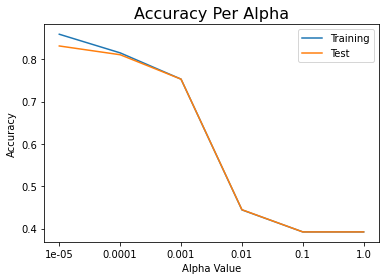

In [56]:
sns.lineplot(data = results_df['Training Accuracy'])
sns.lineplot(data = results_df['Test Accuracy'])

plt.title('Accuracy Per Alpha', size=16)
plt.legend(['Training','Test'])
plt.xlabel('Alpha Value')
plt.ylabel('Accuracy')
x_ticks = range(len(results_df['Alpha']))
plt.xticks(x_ticks, results_df['Alpha'])
plt.show()


**From the plot, the highest accuracy for both training and test datasets was obtained with alpha value of 0.00001**.

### TUNED LASSO REGRESSION WITH ALPHA VALUE 0.00001

In [57]:
lasso_model  = SGDClassifier(loss = 'log', penalty = 'l1', alpha = 0.00001, class_weight = 'balanced')
lasso = lasso_model.fit(X_train, y_train)

# predict the model
lasso_pred = lasso.predict(X_test)

# Accuracy
lasso_accuracy = accuracy_score(y_test, lasso_pred)

#classification report
print(classification_report(y_test, lasso_pred))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79      3908
           1       0.89      0.83      0.86     11179
           2       0.78      0.79      0.79      5010
           3       0.82      0.87      0.84      4997
           4       0.83      0.89      0.86      3406

    accuracy                           0.83     28500
   macro avg       0.82      0.84      0.83     28500
weighted avg       0.84      0.83      0.83     28500



##**SUPPORT VECTOR MACHINE(SVM)**



SVM will be trained with small, medium, large, and extra large data sets using "linear" for kernel, "auto" for gamma, and a C-parameter value of 2. 

####SVM FOR SMALL FEATURES

In [58]:
from sklearn import svm
from sklearn.svm import SVC

cls = svm.SVC(kernel="linear", gamma="auto", C=2)

In [59]:
cls.fit(X_train_small, y_train)
y_predict = cls.predict(X_test_small)

target_names = ['Credit Card', 'Credit Reporting', 'Debt Collection', 'Mortgages & Loans', 'Retail Banking']
print(classification_report(y_test, y_predict, target_names=target_names))

                   precision    recall  f1-score   support

      Credit Card       0.73      0.69      0.71      3908
 Credit Reporting       0.76      0.84      0.80     11179
  Debt Collection       0.77      0.62      0.69      5010
Mortgages & Loans       0.79      0.79      0.79      4997
   Retail Banking       0.81      0.81      0.81      3406

         accuracy                           0.77     28500
        macro avg       0.77      0.75      0.76     28500
     weighted avg       0.77      0.77      0.77     28500



####SVM FOR MEDIUM FEATURES

In [60]:
cls.fit(X_train_medium, y_train)
y_predict = cls.predict(X_test_medium)

print(classification_report(y_test, y_predict, target_names=target_names))

                   precision    recall  f1-score   support

      Credit Card       0.79      0.80      0.79      3908
 Credit Reporting       0.84      0.87      0.85     11179
  Debt Collection       0.79      0.72      0.76      5010
Mortgages & Loans       0.86      0.84      0.85      4997
   Retail Banking       0.85      0.88      0.86      3406

         accuracy                           0.83     28500
        macro avg       0.82      0.82      0.82     28500
     weighted avg       0.83      0.83      0.83     28500



####SVM FOR LARGE FEATURES

In [61]:
cls.fit(X_train_large, y_train)
y_predict = cls.predict(X_test_large)

print(classification_report(y_test, y_predict, target_names=target_names))

                   precision    recall  f1-score   support

      Credit Card       0.79      0.80      0.79      3908
 Credit Reporting       0.84      0.87      0.86     11179
  Debt Collection       0.80      0.74      0.77      5010
Mortgages & Loans       0.86      0.84      0.85      4997
   Retail Banking       0.85      0.88      0.86      3406

         accuracy                           0.83     28500
        macro avg       0.83      0.82      0.83     28500
     weighted avg       0.83      0.83      0.83     28500



####SVM FOR EXTRA LARGE FEATURES

In [62]:
cls.fit(X_train_xlarge, y_train)
y_predict = cls.predict(X_test_xlarge)

print(classification_report(y_test, y_predict, target_names=target_names))

                   precision    recall  f1-score   support

      Credit Card       0.78      0.80      0.79      3908
 Credit Reporting       0.85      0.87      0.86     11179
  Debt Collection       0.81      0.75      0.78      5010
Mortgages & Loans       0.86      0.84      0.85      4997
   Retail Banking       0.86      0.87      0.87      3406

         accuracy                           0.84     28500
        macro avg       0.83      0.83      0.83     28500
     weighted avg       0.84      0.84      0.84     28500



###**COMPARISON SCORES OF DIFFERENT MODELS**



In [73]:
from sklearn.metrics import f1_score
labels = [0, 1, 2,3,4]


models = [dummy_test_pred, xlarge_rf_pred, per_test_pred, lasso_pred, y_predict]
scores_table = []
accuracy = []

for i in models: 
  accuracy_scores = accuracy_score(i, y_test)
  f1_scores = f1_score(i, y_test, average = None)
  f1_scores_with_labels = {label:score for label,score in zip(target_names, f1_scores)}
  scores_table.append(f1_scores_with_labels)
  accuracy.append(accuracy_scores)


###**F1 SCORES**

In [79]:
f1_scores = pd.DataFrame(scores_table)
f1_table = f1_scores.round(decimals = 2)

f1_table

,Credit Card,Credit Reporting,Debt Collection,Mortgages & Loans,Retail Banking
0,0.00,0.56,0.00,0.00,0.00
1,0.78,0.87,0.78,0.84,0.84
2,0.76,0.84,0.74,0.82,0.84
3,0.79,0.86,0.79,0.84,0.86
4,0.79,0.86,0.78,0.85,0.87


In [81]:
f1_table.insert(0, 'Models', ['Baseline','Random Forest','Perceptron', 'SGD Lasso', 'SVM'])
pd.DataFrame(f1_table)

,Models,Credit Card,Credit Reporting,Debt Collection,Mortgages & Loans,Retail Banking
0,Baseline,0.00,0.56,0.00,0.00,0.00
1,Random Forest,0.78,0.87,0.78,0.84,0.84
2,Perceptron,0.76,0.84,0.74,0.82,0.84
3,SGD Lasso,0.79,0.86,0.79,0.84,0.86
4,SVM,0.79,0.86,0.78,0.85,0.87


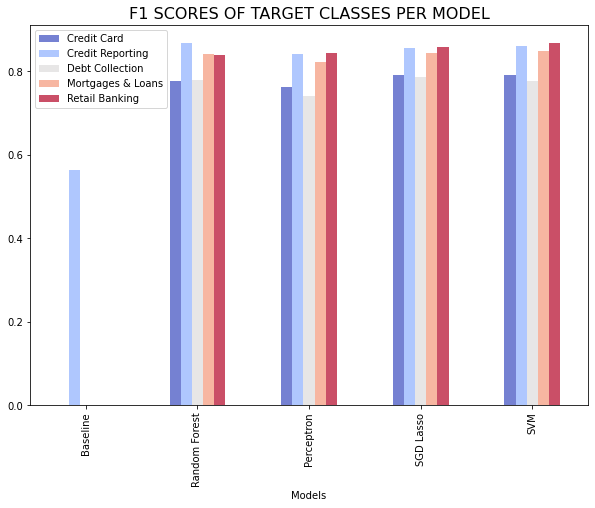

In [82]:
#Bargraph for Comparison of Metrics for Each Model

f1_scores.plot(x="Models", y= ['Credit Card','Credit Reporting','Debt Collection','Mortgages & Loans','Retail Banking'], kind = 'bar',
               figsize = (10,7), colormap = 'coolwarm', alpha = 0.7)
plt.title('F1 SCORES OF TARGET CLASSES PER MODEL', size = 16)
plt.show()

###**ACCURACY**

In [83]:
# merge accuracy and f1_scores dataframe
accuracy = pd.DataFrame(accuracy, columns = ['Accuracy_score'])
accuracy_table = accuracy.round(decimals = 2)

accuracy_table.insert(0, 'Models', ['Baseline','Random Forest','Perceptron', 'SGD Lasso','SVM'])
accuracy_table

,Models,Accuracy_score
0,Baseline,0.39
1,Random Forest,0.83
2,Perceptron,0.81
3,SGD Lasso,0.83
4,SVM,0.84


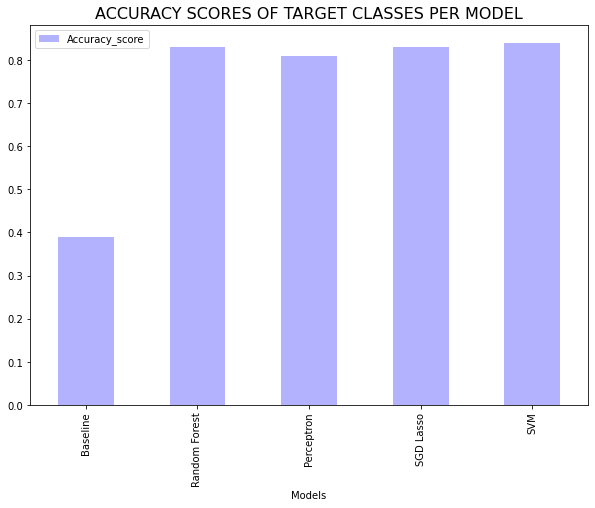

In [85]:
#Bargraph for Comparison of Accuracy for Each Model

accuracy_table.plot(x="Models", y= ['Accuracy_score'], kind = 'bar',figsize = (10,7), colormap = 'winter', alpha = 0.3)
plt.title('ACCURACY SCORES OF TARGET CLASSES PER MODEL', size = 16)
plt.show()

**Overall,  SVM outperfom other models with highest accuracy scores and higher F1 scores for target classes.**